In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import h5py
from glob import glob
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
columns_x = []
columns_y = []
columns_z = []

for i in range(18):
    columns_x.append(f'{i}_x')
    columns_y.append(f'{i}_y')
    columns_z.append(f'{i}_z')

experiment_columns_initial = ['Object', 'Pose', 'Experiment', 'Length', 'Accepted']



In [5]:
frames = []
lens = []
rejects = 0
accepts = 0

exp_df_1 = pd.DataFrame(columns=experiment_columns_initial)

short_exp = None

print('Reading experiment data from h5 files')
for file_path in tqdm(glob('Data/tactile_object_recognition/*.h5')):
    hf = h5py.File(file_path, 'r')
    name = list(hf.keys())[0]
    poses = list(hf[name].keys())
    #print(f'{name} dataset contains {len(poses)} poses')
    #object_folder = f'{parent_dir}/{name}'
    for pose in poses:
        experiments = list(hf[f'{name}/{pose}'].keys())
        #print(f'\t Loading {pose} containing {len(experiments)} experiments')
        #pose_folder = f'{object_folder}/{pose}'
        for experiment in experiments:
            path = f'{name}/{pose}/{experiment}'
            df_x = pd.DataFrame(np.array(hf[f'{path}/tactile_data_normalized/x']).T, columns=columns_x)
            df_y = pd.DataFrame(np.array(hf[f'{path}/tactile_data_normalized/y']).T, columns=columns_y)
            df_z = pd.DataFrame(np.array(hf[f'{path}/tactile_data_normalized/z']).T, columns=columns_z)

            result = pd.concat([df_x, df_y, df_z], axis=1, join="inner")

            result['timestamp'] = np.array(hf[f'{path}/tactile_timestamps'])
            result['change_label'] = np.array(hf[f'{path}/tactile_changes_label'])
            #result.to_excel(f'{pose_folder}/{experiment}.xlsx')

            exp_length = (len(result)/180)
            lens.append(exp_length)
            if exp_length < 15:
                rejects = rejects + 1
                is_in = False
                if(exp_length < 12 and exp_length > 9):
                    short_exp = result
            else:
                is_in = True
                accepts = accepts + 1
                result['object'] = name
                result['pose'] = pose
                result['experiment'] = experiment
                frames.append(result)

            exp_df_1.loc[len(exp_df_1)] = [name, pose, experiment, exp_length, is_in]
            
    hf.close()
df = pd.concat(frames)
print(f'{accepts} experiments accepted out of {len(lens)}')

Reading experiment data from h5 files



426 experiments accepted out of 571


In [ ]:
571-426


In [ ]:
exp_df_1.to_excel('Initial_rejects_data.xlsx')
exp_df_1

In [ ]:
lens.col.unique()

In [ ]:
#lens = pd.DataFrame({'val': lens, 'col':['1' if int(x)>15 else '0' for x in lens]})
pallete = {'0': '#FF8021', '1': '#4E67C8'}
#Plot showing threshold
fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25 )
plt.xlabel('Experiment Length', fontsize=40).set_color('#595959')
plt.ylabel('Count', fontsize=40).set_color('#595959')
plt.title('Experiment Length Distribution', fontsize=50).set_color('#595959')
hs = sns.histplot(lens, x='val', hue='col',bins= 50, ax=ax, palette=pallete)
ax.set_xticks(np.arange(25))
hs.vlines(x=[15], ymin=0, ymax=125, colors=['tab:red'], ls='--', lw=2, label='Threshold')
plt.legend(fontsize=30, title_fontsize=15)
plt.text(7.5,70,'Threshold = 15 seconds', fontsize=25)
plt.show()

In [ ]:
df

In [ ]:
initial_rows = 1635859
only_longs = 1533332

In [ ]:
initial_rows-only_longs

In [ ]:
objects = df.object.unique()
weights = [28.0,165.0,24.0,210.0,16.0,78.0,125.0,227.0,127.0,62.0]

weight_df = pd.DataFrame()

weight_df['object'] = objects
weight_df['Weights'] = weights

weight_df
final_df = df.merge(weight_df, left_on='object', right_on='object')

Text(0.5, 1.0, 'Distribution of weights in the dataset')

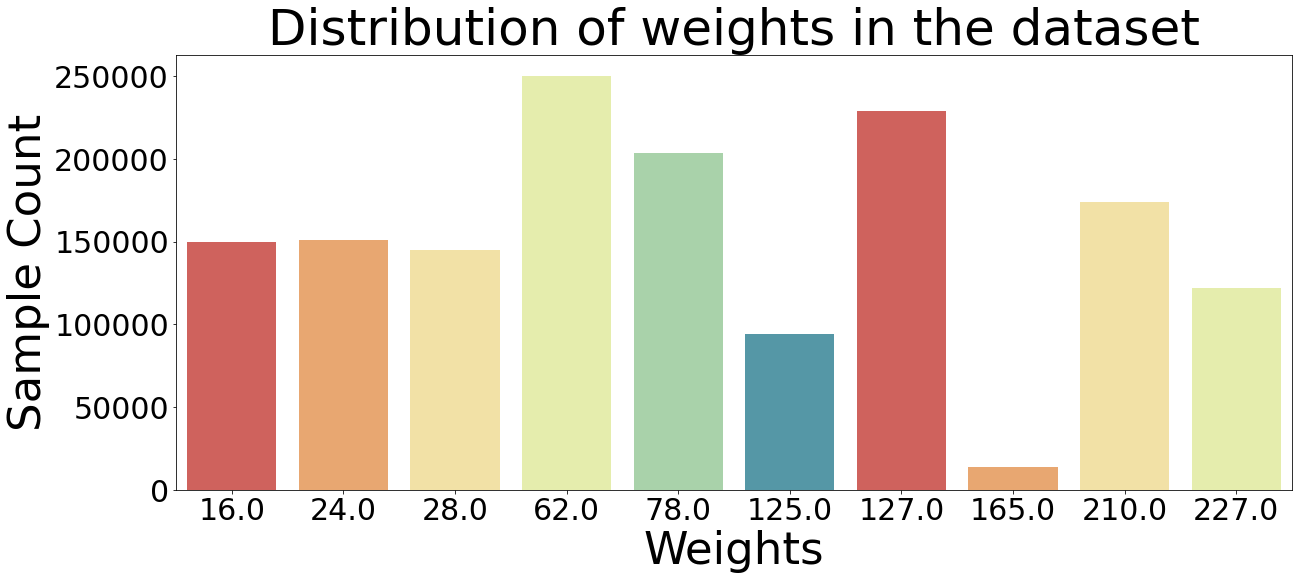

In [ ]:
f, ax = plt.subplots(1, figsize=(20, 8))
sns.countplot(x='Weights', data=final_df, palette=sns.color_palette("Spectral", as_cmap=False))
plt.xticks(fontsize=30 )
plt.yticks(fontsize=30 )
plt.xlabel('Weights', fontsize=45)
plt.ylabel('Sample Count', fontsize=45)
plt.title('Distribution of weights in the dataset', fontsize=50)

In [ ]:
count = 0
selected_count = 0
selected = []
lift_add_count = 0
exp_df_2 = pd.DataFrame(columns=['Object', 'Pose', 'Experiment', 'Accepted', 'Note'])

print('Extracting lift phase and rejecting invalid experiments...')
for object in tqdm(objects):
    object_df = final_df.loc[final_df['object'] == object]
    poses = object_df.pose.unique()
    #print(f'Object {object} has {len(poses)} poses')
    for pose in poses:
        pose_df = object_df[object_df['pose'] == pose]
        experiments = pose_df.experiment.unique()
        for experiment in experiments:
            exp_df = pose_df[pose_df['experiment']==experiment].copy()
            count = count + 1
            
            #Getting rolling mean to 20
            exp_df['rolling_mean'] = exp_df['change_label'].rolling(window=20).mean()
            
            #Gettin strips of 0s on rolling mean
            idx_pairs = np.where(np.diff(np.hstack(([False],exp_df['rolling_mean'] ==0,[False]))))[0].reshape(-1,2)

            #Get length of strips
            lengths = np.diff(idx_pairs,axis=1).flatten()

            #Removing strips less that 100 samples long
            idx_pairs = idx_pairs[lengths>100]

            #Check if strips are over 10 seconds
            if((len(lengths[lengths > 1800])>0)):
                exp_df_2.loc[len(exp_df_2)] = [object, pose, experiment, False, 'Strip too long' ]
                print('Long strip: ', object, pose, experiment)
                continue
            #Check if there are less than 2 long strips
            elif((len(idx_pairs)<2)):
                exp_df_2.loc[len(exp_df_2)] = [object, pose, experiment, False, 'Less than 2 strips' ]
                continue
            else:
                selected_count = selected_count + 1

                #Getting the longest 4 strips
                if(len(idx_pairs)>3):
                    longest_4 = np.flip(np.argpartition(np.diff(idx_pairs,axis=1).flatten(), -4)[-4:])
                    longest_4_idx = idx_pairs[longest_4]
                else:
                    longest_4_idx = idx_pairs

                #Arranging strips by time, earlier first
                a = longest_4_idx.tolist() 
                longest_4_idx = np.array(sorted(a, key=lambda a_entry: a_entry[0]))

                #Getting dataframe index
                longest_4_idx = longest_4_idx + exp_df.index[0]
                
                #Initializing lift phase column
                exp_df['lift'] = False
                
                #Getting the second strip location
                lift_start = longest_4_idx[1][0]
                lift_end = longest_4_idx[1][1]

                #Setting the lift areas to ture
                exp_df.loc[lift_start:lift_end, 'lift'] =  True
                #If small interruption during lift, add the rest of the portion too
                remark = 'Normal'
                if(len(longest_4_idx)>2):
                    next_break_length = longest_4_idx[2][0]-longest_4_idx[1][1]
                    next_break_mean = exp_df.loc[longest_4_idx[1][1]: longest_4_idx[2][0], "rolling_mean"].mean()
                    if((next_break_length<90) and (next_break_mean<0.4)):
                        lift_start = longest_4_idx[2][0]
                        lift_end = longest_4_idx[2][1]
                        exp_df.loc[lift_start:lift_end, 'lift'] =  True
                        lift_add_count = (lift_end-lift_start) + lift_add_count
                        remark = 'Appended tail'
                
                exp_df_2.loc[len(exp_df_2)] = [object, pose, experiment, True, remark ]
                selected.append(exp_df.drop(['rolling_mean'], axis=1))

print(f'Selected {selected_count} out of {count} experiments')

cleaned_df = pd.concat(selected)


NameError: name 'pd' is not defined

<ipython-input-159-85da2c6a5e4e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels([0,1,2,3])
<ipython-input-159-85da2c6a5e4e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels([0,1,2,3,4,5,6])


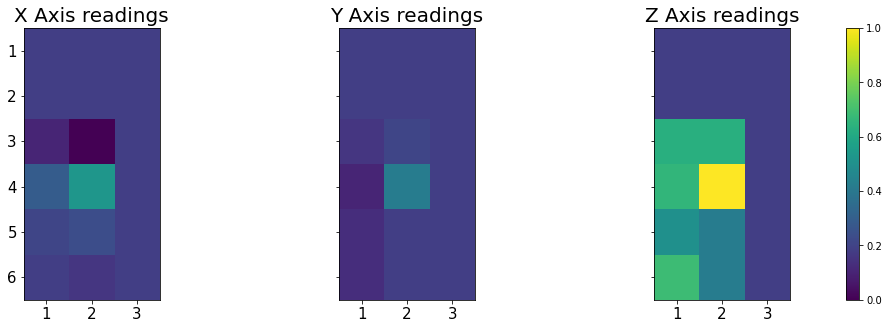

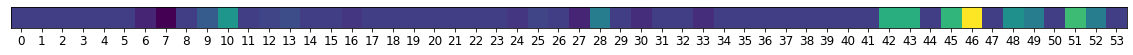

In [159]:
sample = np.array(cleaned_df.sample(1).iloc[:,:54])[0]


<ipython-input-189-b0b9de52fecb>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels([0,1,2,3])


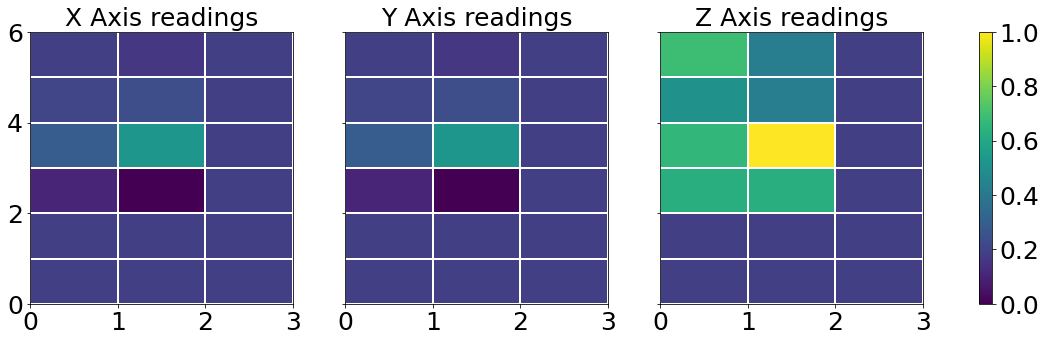

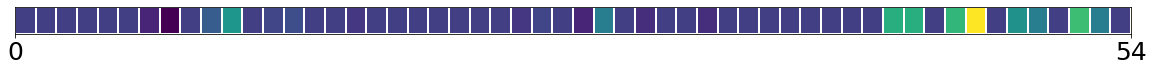

In [189]:

x = sample[0:18]
y = sample[18:36]
z = sample[36:54]

from turtle import left
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt


min =  sample.min()
max = sample.max()

fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(20,5))
shape = (6,3)
cmap=cm.get_cmap('viridis')
normalizer=Normalize(0,1)
im=cm.ScalarMappable(norm=normalizer)
ax[0].pcolormesh(x.reshape(shape), edgecolors='w', linewidth=2, vmin=min, vmax=max)
ax[0].set_title('X Axis readings', fontsize=25)

ax[1].pcolormesh(x.reshape(shape), edgecolors='w', linewidth=2, vmin=min, vmax=max)
ax[1].set_title('Y Axis readings', fontsize=25)
ax[2].pcolormesh(z.reshape(shape), edgecolors='w', linewidth=2, vmin=min, vmax=max)
ax[2].set_title('Z Axis readings', fontsize=25)
cbar = fig.colorbar(im, ax=ax.ravel().tolist())
cbar.ax.tick_params(labelsize=25) 
for a in ax:
    a.tick_params(labelsize=25)
    a.set_xticklabels([0,1,2,3])
    a.grid(which='minor', color='w', linestyle='-', linewidth=5)
    # a.set_yticklabels([0,1,2,3,4,5,6])
    # a.set_xlim(right=3, left=0) #xmax is your value
    # a.set_ylim(top=0, bottom=6) #xmin is your value
plt.figure(figsize=(20,0.5))
plt.pcolormesh(sample.reshape(1,54), edgecolors='w', linewidth=2, vmin=min, vmax=max)
plt.yticks([])
plt.xticks([0,54],fontsize=25)
plt.show()

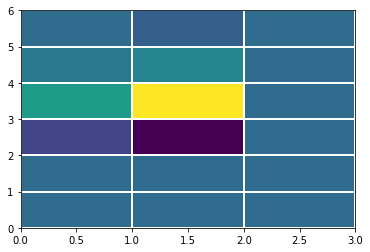

In [179]:
plt.pcolormesh(x.reshape(shape), edgecolors='w', linewidth=2)

In [ ]:
#One spike
#exp = final_df.loc[final_df['object'] == 'adversarialPipe'][final_df['pose'] == 'Pose4'][final_df['experiment'] == 'Exp14']
#exp = final_df.loc[final_df['object'] == 'adversarialPipe'][final_df['pose'] == 'Pose4'][final_df['experiment'] == 'Exp15']
#exp = final_df.loc[final_df['object'] == 'adversarialPipe'][final_df['pose'] == 'Pose4'][final_df['experiment'] == 'Exp8']
#Small Island
#exp = final_df.loc[final_df['object'] == 'adversarialPipe'][final_df['pose'] == 'Pose4'][final_df['experiment'] == 'Exp11']

#Normal
#exp = final_df.loc[final_df['object'] == 'adversarialPipe'][final_df['pose'] == 'Pose4'][final_df['experiment'] == 'Exp7']

#Long strip
exp = final_df.loc[final_df['object'] == 'SpoolSolder'][final_df['pose'] == 'Pose5'][final_df['experiment'] == 'Exp10']

#Interrupted lift
#exp = final_df.loc[final_df['object'] == 'adversarialPipe'][final_df['pose'] == 'Pose5'][final_df['experiment'] == 'Exp12']

#Interrupted tail, unfixed
#exp = final_df.loc[final_df['object'] == 'adversarialPipe'][final_df['pose'] == 'Pose5'][final_df['experiment'] == 'Exp3']

#exp = final_df.loc[final_df['object'] == 'brush'][final_df['pose'] == 'Pose4'][final_df['experiment'] == 'Exp13']

#exp = short_exp

exp['rolling_mean'] = exp['change_label'].rolling(window=20).mean()
f, ax = plt.subplots(1, figsize=(20, 8))
plot = sns.lineplot(data=exp, x='timestamp', y='rolling_mean', ax=ax)#, label='Rolling mean of change label')
# plot.set(xticklabels=[])
# plot.set(xlabel=None)
plt.xticks(fontsize=35 )
plt.yticks(fontsize=35 )
plt.xlabel('Timestamp', fontsize=40).set_color('#595959')
plt.ylabel('Rolling mean', fontsize=40).set_color('#595959')
plt.title('Experiment change label rolling mean', fontsize=50).set_color('#595959')
#plt.legend(fontsize=20, title_fontsize=15)
idx_pairs = np.where(np.diff(np.hstack(([False],exp['rolling_mean'] ==0,[False]))))[0].reshape(-1,2)
#Removing islands less than 100 samples or over 10 seconds
lengths = np.diff(idx_pairs,axis=1).flatten()
if((len(lengths[lengths > 1800])>0)):
    print('Experiment invalid, Very long strip found!')

elif((len(idx_pairs)<2)):
    print('Experiment invalid!!! Less than 2 strips')
else:
    idx_pairs = idx_pairs[lengths>100]
    if(len(idx_pairs)>2):
        longest_4 = np.flip(np.argpartition(np.diff(idx_pairs,axis=1).flatten(), -4)[-4:])
        longest_4_idx = idx_pairs[longest_4]
    else:
        longest_4_idx = idx_pairs

    a = longest_4_idx.tolist() 
    longest_4_idx = np.array(sorted(a, key=lambda a_entry: a_entry[0]))

    longest_4_idx = longest_4_idx + exp.index[0]
    exp['lift'] = False
    lift_start = longest_4_idx[1][0]
    lift_end = longest_4_idx[1][1]
    exp.loc[lift_start:lift_end, 'lift'] =  True
    #If small interruption during lift, add the rest of the portion too
    if(len(longest_4_idx)>2):
        next_break_length = longest_4_idx[2][0]-longest_4_idx[1][1]
        next_break_mean = exp.loc[longest_4_idx[1][1]: longest_4_idx[2][0], "rolling_mean"].mean()
        if((next_break_length<90) and (next_break_mean<0.4)):
            lift_start = longest_4_idx[2][0]
            lift_end = longest_4_idx[2][1]
            exp.loc[lift_start:lift_end, 'lift'] =  True
            print('Appending leftout lift tail!')

    sns.lineplot(data=exp, x='timestamp', y='lift', ax=ax, color='red', label='Lift Phase', ls='--')
    plt.legend(fontsize=35, title_fontsize=35)
    plt.show()

In [ ]:

cleaned_df

In [ ]:
1442616 - 165805

In [ ]:
1276811 - 32883

In [ ]:
198688 - 32883

In [ ]:
1533332 - 1475499


In [8]:
lift_only = cleaned_df.loc[cleaned_df['lift']].drop(['lift', 'timestamp', 'change_label', 'object', 'pose', 'experiment'], axis=1)
lift_only


,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,9_z,10_z,11_z,12_z,13_z,14_z,15_z,16_z,17_z,Weights
1126,0.0,0.0,0.0,-2.0,-1.0,0.0,21.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
1127,0.0,0.0,0.0,-2.0,-1.0,0.0,21.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
1128,0.0,0.0,0.0,-2.0,-1.0,0.0,21.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
1129,0.0,0.0,0.0,-2.0,-1.0,0.0,21.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
1130,0.0,0.0,0.0,-2.0,-1.0,0.0,21.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,...,5.0,0.0,0.0,90.0,1.0,0.0,96.0,8.0,0.0,62.0
1531055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,...,5.0,0.0,0.0,90.0,1.0,0.0,96.0,8.0,0.0,62.0
1531056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,...,5.0,0.0,0.0,90.0,1.0,0.0,96.0,8.0,0.0,62.0
1531057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,...,5.0,0.0,0.0,90.0,1.0,0.0,96.0,8.0,0.0,62.0


In [ ]:
lift_only.to_excel('lift_only')

In [ ]:
sns.countplot(x='Weights', data=lift_only)

In [ ]:
sample_10K = lift_only.sample(n=10000, random_state=10)
X = lift_only.iloc[:,:54]
y = np.array(lift_only.Weights)
sns.countplot(x='Weights', data=lift_only)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
GBR = GradientBoostingRegressor()
parameters = {'learning_rate': [0.01,0.1],
                  'subsample'    : [0.9, 0.5, 0.1],
                  'n_estimators' : [50,100],
                 }

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 5, n_jobs=8, verbose=5)
grid_GBR.fit(X_train, y_train)


In [ ]:
best_GBR = grid_GBR.best_estimator_
best_GBR

In [ ]:
best_GBR = GradientBoostingRegressor(subsample=0.9)
best_GBR.fit(X_train, y_train)

In [ ]:
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [ ]:
def print_scores(model, X_test, y_test):
    y_pred = best_GBR.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'R² score: {r2} \t Mean Absolute Error: {mae} \t Mean Squared Error: {mse}')

In [ ]:
print_scores(best_GBR, X_test, y_test)

In [ ]:
y_pred = best_GBR.predict(X_test)
result_df = pd.DataFrame(dict(Actual=y_test, Predicted=y_pred))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]
result_df

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(18,10))
# Draw a nested boxplot to show bills by day and time
ax = sns.boxplot(x="Weights", y="Predicted",
            data=result_df)
ax.set_xlabel("Weights",fontsize=30)
ax.set_ylabel("Predicted",fontsize=30)
ax.set_title('Weight estimation performance per weight', fontsize=30)
ax.tick_params(labelsize=20)


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg = LinearRegression()
parameters = {
              "fit_intercept": [True, False],
              'normalize': [True, False], 
             }

grid = GridSearchCV(estimator=reg, param_grid = parameters, cv = 5, n_jobs=6, verbose=3)    
grid.fit(X_train, y_train)
reg = grid.best_estimator_
reg.score(X_test,y_test)

In [ ]:
print_scores(reg,X_test, y_test )

In [ ]:
y_pred = reg.predict(X_test)
result_df = pd.DataFrame(dict(Actual=y_test, Predicted=y_pred))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]
result_df

In [ ]:
def run_parameter_search(model, parameters, x_test,y_test, x_train, y_train):
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=6, verbose=3)   
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    print(f'Best model: {best_model}')
    print_scores(best_model, x_test,y_test)
    return best_model

In [ ]:
from sklearn.linear_model import HuberRegressor

regressor = HuberRegressor(max_iter=10000)
parameters = {
              "epsilon": [1.10,1.20,1.30,1.40],
              'alpha': [0.0001,0.001,0.1], 
             }

run_parameter_search(regressor, parameters, X_test, y_test, X_train, y_train)


In [ ]:
sample_100K = lift_only.sample(n=100000, random_state=10)
X = np.array(sample_100K.iloc[:,:54])
y = np.array(sample_100K.Weights)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer

from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

nm = Normalizer()

X_train = nm.fit_transform(X_train)
X_test = nm.transform (X_test)

X_train = X_train.reshape((X_train.shape[0]),3,6,3)
X_test = X_test.reshape((X_test.shape[0]),3,6,3)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
batch_size = 1000
epochs =20000
# input image dimensions
img_rows, img_cols = 6, 3
input_shape = (3, img_rows, img_cols)

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

In [ ]:
!rm -rf ./content/drive/MyDrive/MS_Project/Log
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/MS_Project/Log

In [ ]:
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import TensorBoard

import datetime, os


In [ ]:

logdir = os.path.join("/content/drive/MyDrive/MS_Project/Log", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [ ]:
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape = input_shape))

model.add(MaxPooling2D(pool_size=(2, 2),  padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2),  padding='same'))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(258, activation='relu'))

model.add(Dense(1, activation='linear'))


model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as  mean_squared_error
                  optimizer='adam',
                  metrics=[r2_keras, mean_absolute_error] # you can add several if needed
                 )

model.summary()

In [ ]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test, verbose=3)

In [ ]:
model.save('/content/drive/MyDrive/MS_Project/Models/CNN_only_v2')

In [ ]:
y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred.flatten())

In [ ]:
result_df = pd.DataFrame(dict(Actual=np.array(y_test), Predicted=y_pred.flatten()))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]
result_df.to_excel('CNN_result.xlsx')

In [ ]:
sns.set_theme(style="ticks")
plt.figure(figsize=(18,10))
# Draw a nested boxplot to show bills by day and time
ax = sns.boxplot(x="Weights", y="Predicted",
            data=result_df)
ax.set_xlabel("Weights",fontsize=30)
ax.set_ylabel("Predicted",fontsize=30)
ax.set_title('Weight estimation performance per weight', fontsize=30)
ax.tick_params(labelsize=20)

In [ ]:
!tensorboard dev upload --logdir /content/drive/MyDrive/MS_Project/Log --name "CNN only v2" --description "Weight estimation using uSkin sensor data only" 